# 필요한 패키지 다운 및 분석 환경 설정

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path
# from torchvision.io import read_image
from PIL import Image
import logging

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from __future__ import print_function, division

from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torchvision.transforms as transforms

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Load (by using imageFolder)

In [ ]:
data_dir = '/content/drive/Shareddrives/2022 데이터 청년 캠퍼스/pest/'

train_data = '/content/drive/Shareddrives/2022 데이터 청년 캠퍼스/pest/train'
test_data = '/content/drive/Shareddrives/2022 데이터 청년 캠퍼스/pest/test'

image data 전처리(resize, normalization)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(84),  #img 사이즈를 변경한다.
        #transforms.Resize(128),              #img 사이즈를 사이즈로 변경한다. 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.497, 0.529, 0.337], [0.161, 0.157, 0.162])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(84),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.ToPILImage(),
        #transforms.CenterCrop(),  #가운데 부분을 사이즈 크기로 자른다.
        transforms.Normalize([0.487, 0.529, 0.337], [0.166, 0.159, 0.160])
    ]),
}

torch.utils.data.DataLoader (불러온 데이터셋 변수, batch_size=1, shuffle=False, sampler=None,
batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False,
timeout=0, worker_init_fn=None, multiprocessing_context=None )


**parameters**
- batch_size : 모델을 한 번 학습시킬 때 몇 개의 데이터를 넣을지 정한다. 1 배치가 끝날때마다 파라미터를 조정한다.

- shuffle : 데이터를 섞을지 정한다.

- num_workers : 몇개의 subprocesses를 가동시킬건지 정한다.

- drop_last : 배치별로 묶고 남은 데이터를 버릴지 (True) 여부를 정한다.

 

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print("class_names : ", class_names)
print("\n")
print("datasets_sizes : ", dataset_sizes)
print("\n")
print("image_datasets : ", image_datasets)

class_names :  ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']


datasets_sizes :  {'train': 410, 'test': 123}


image_datasets :  {'train': Dataset ImageFolder
    Number of datapoints: 410
    Root location: /content/drive/Shareddrives/2022 데이터 청년 캠퍼스/pest/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(84, 84), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.497, 0.529, 0.337], std=[0.161, 0.157, 0.162])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 123
    Root location: /content/drive/Shareddrives/2022 데이터 청년 캠퍼스/pest/test
    StandardTransform
Transform: Compose(
               RandomRe

### 시각화

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

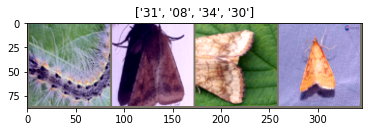

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### model 실행 결과 시각화

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Domain Adaptation

### GRL Lambda 계산하는 class 생성


두 데이터셋의 domain 분포 거리를 줄이기 위해 두 domain 거리를 측정할 수 있는 class가 필요하다. 이 class가 GradientReversalFn이다. 해당 class는 domain 거리를 측정해주는 역할을 한다. 

In [ ]:
from torch.autograd import Function

In [ ]:
class GradientReversalFn(Function):
  @staticmethod
  def forward(ctx, x, alpha):
    #store context for backprop
    ctx.alpha=alpha
    
    return x   #forward pass is a no-op

  @staticmethod
  def backward(ctx, grad_output):

    #Backward pass is just to -alpha the gradient
    output= - ctx.alpha * grad_output

    return output, None  #Must return same num as inputs to forward()

### DACNN model

목적: target domain error를 줄이는 것

source domain에서 classify를 잘하고, source domain과 target domain과의 거리가 가깝다면 target error를 작게 출력하는 것이 가능하다.DACNN모델의 구조는 classification에서 class label을 구분하는 task와 source와 target의 domain을 구분하는 두 task를 동시에 진행한다. 데트워크의 첫 층은 두 domain을 공유하고 feature로부터 class label을 구분하는 층과 target에 동시에 포함되는 domain특징을 지우고 class 분류만 하여 특징 추출하는 층이 있다. 이를 각각 feature_extractor, class classifier, domain classifier로 명칭했다.  

In [ ]:
class DACNN(nn.Module):
  def __init__(self):
    super().__init__()

    in_channel=3
    out_channel=3

    self.feature_extractor = nn.Sequential(
      nn.Conv2d(in_channel,16,kernel_size=3,padding=1,stride=1),    #(img_siz+2*padding-kernelsize)/stride+1
      nn.BatchNorm2d(16), 
      nn.ReLU(True),  
      nn.MaxPool2d(2),  

      nn.Conv2d(16,64,kernel_size=3,padding=1,stride=1),   #(img_siz+2*padding-kernelsize)/stride+1
      nn.BatchNorm2d(64), 
      nn.ReLU(True),
      nn.MaxPool2d(2),  

      nn.Conv2d(64, 128,kernel_size=3,padding=1,stride=1),   
      nn.BatchNorm2d(128), 
      nn.ReLU(True),
      nn.MaxPool2d(2),  

      nn.Conv2d(128,256,kernel_size=3,padding=1,stride=1),   
      nn.BatchNorm2d(256), 
      nn.ReLU(True),
      nn.MaxPool2d(2), 
      )


    self.num_cnn_features=6400          #input / shape 사이즈 동일해야 오류없이 출력 가능

    self.class_classifier=nn.Sequential(               # class_classifier layer 생성
        nn.Linear(self.num_cnn_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(True),

        nn.Linear(256, 84),
        nn.BatchNorm1d(84),
        nn.ReLU(True),
        
        nn.Linear(84,out_channel),
        nn.LogSoftmax(dim=1),
    )

    self.domain_classifier=nn.Sequential(
        nn.Linear(self.num_cnn_features, 84),
        nn.BatchNorm1d(84),
        nn.ReLU(True),

        nn.Linear(84,out_channel),
        nn.LogSoftmax(dim=1),
    )

  def forward(self, x, grl_lamda=1.0):    
    #handle single channel input by expanding the singleton dimention
    x = x.expand(x.data.shape[0], 3, image_size, image_size)
    
    features = self.feature_extractor(x)
    features = features.view(-1, self.num_cnn_features)
    features_grl = GradientReversalFn.apply(features,grl_lamda)
    class_pred = self.class_classifier(features)                # classify on regular features
    domain_pred=self.domain_classifier(features_grl)            # classify on  features after GRL
    
    return class_pred, domain_pred

In [ ]:
tr=dataloaders['train']
te=dataloaders['test']

In [ ]:
print(type(te))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
model=DACNN()


x0_s,y0_s = next(iter(tr))
x0_t,y0_t = next(iter(te))

print('source domain input: ', x0_s.shape, y0_s.shape)
print('target domain input: ', x0_t.shape, y0_t.shape)

source domain input:  torch.Size([4, 3, 84, 84]) torch.Size([4])
target domain input:  torch.Size([4, 3, 84, 84]) torch.Size([4])


In [ ]:
image_size=84

In [ ]:
yhat0_s_c, yhat0_s_d=model(x0_s)
yhat0_t_x, yhat0_t_d=model(x0_t)

print('yhat0_s_c: \n ', yhat0_s_c, yhat0_s_c.shape)
print('yhat0_t_d: \n ', yhat0_t_d, yhat0_t_d.shape)

yhat0_s_c: 
  tensor([[-0.5761, -1.3798, -1.6806],
        [-1.2513, -0.8425, -1.2615],
        [-0.8212, -1.1028, -1.4776],
        [-0.7895, -1.2140, -1.3906]], grad_fn=<LogSoftmaxBackward0>) torch.Size([4, 3])
yhat0_t_d: 
  tensor([[-1.2861, -0.7525, -1.3765],
        [-1.4185, -0.9731, -0.9676],
        [-1.3352, -1.1141, -0.8948],
        [-0.8246, -1.9481, -0.8698]], grad_fn=<LogSoftmaxBackward0>) torch.Size([4, 3])


# Train

In [ ]:
device='cpu'
device=torch.device(device)

In [ ]:
train_dataset=torchvision.datasets.ImageFolder(train_data, transform=data_transforms['train'])
test_dataset= torchvision.datasets.ImageFolder(test_data, transform=data_transforms['test'])

In [ ]:
batch_size=3

In [ ]:
train_l=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_l= torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
n_epochs=10
in_channel=3
out_channel=3
image_size=84

model=DACNN().to(device)

optimizer=optim.Adam(model.parameters(), lr=1e-3)

# two loss functions 
loss_fn_class=torch.nn.NLLLoss()
loss_fn_domain=torch.nn.NLLLoss()

In [ ]:
# train the same num of batches from both dataset
max_batches = min(len(train_dataset), len(test_dataset))
max_batches

123

In [ ]:
def test(dataset):

    #cuda = True
    cudnn.benchmark = True
    batch_size = 128
    #image_size = 84
    grl = 0

    my_net=DACNN()
    my_net = my_net.eval()

    len_dataloader = len(dataset)
    data_target_iter = iter(dataset)

    i = 0
    n_total = 0
    n_correct = 0

    while i < len_dataloader:

        # test model using target data
        data_target = next(data_target_iter)
        t_img, t_label = data_target


        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)

        class_output, _ = my_net(x=input_img)
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(class_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

        i += 1

    accu = n_correct.data.numpy() * 1.0 / n_total

    print('epoch: %d, accuracy : %f' % (i, accu))

In [ ]:
for epoch_idx in range(n_epochs):
  print(f'Epoch {epoch_idx+1:04d}/{n_epochs:04d}', end='\n========================\n')

  dl_source_iter=iter(train_dataset)
  dl_target_iter=iter(test_dataset)


  for batch_idx in range(max_batches):
    optimizer.zero_grad()

    p=float(batch_idx + epoch_idx* max_batches)/(n_epochs * max_batches)
    grl_lambda=2./(1.+np.exp(-10*p))-1

    # Train: source  domain
    x_s,y_s=next(dl_source_iter)
    y_s_domain=torch.zeros(batch_size, dtype=torch.long)

    class_pred, domain_pred=model(x_s,grl_lambda)
    #loss_s_label=loss_fn_class(class_pred, y_s)
    loss_s_domain=loss_fn_domain(domain_pred, y_s_domain)

    # Train: target domain
    x_t, _ =next(dl_target_iter)
    y_t_domain=torch.ones(batch_size, dtype=torch.long)
    
    _, domain_pred=model(x_t, grl_lambda)
    loss_t_domain=loss_fn_domain(domain_pred, y_t_domain)

    #최적화
    loss=loss_t_domain+loss_s_domain
    loss.backward()
    optimizer.step()

    print(f'[{batch_idx+1}/{max_batches}]'
          #f'class loss: {loss_s_label.item(): .4f}'
          f's_domain_loss: {loss_s_domain.item(): .4f}    /    t_domain loss: {loss_s_domain.item(): .4f}    /    grl_lambda: {grl_lambda: .3f}'
          )
  #정확도 출력
  print('\n')
  accu_s = test(train_dataset)
  print('Accuracy_s: ', accu_s, '%')
  #print('Accuracy_s: {: .%4f}%'.format(accu_s))
  accu_t = test(test_dataset)
  print('Accuracy_t: ', accu_t, '%')
  #print('Accuracy_t: {: .%4f}%'.format(accu_t))

Epoch 0001/0010
[1/123]s_domain_loss:  0.7095    /    t_domain loss:  0.7095    /    grl_lambda:  0.000
[2/123]s_domain_loss:  0.7094    /    t_domain loss:  0.7094    /    grl_lambda:  0.004
[3/123]s_domain_loss:  0.7092    /    t_domain loss:  0.7092    /    grl_lambda:  0.008
[4/123]s_domain_loss:  0.7090    /    t_domain loss:  0.7090    /    grl_lambda:  0.012
[5/123]s_domain_loss:  0.7089    /    t_domain loss:  0.7089    /    grl_lambda:  0.016
[6/123]s_domain_loss:  0.7088    /    t_domain loss:  0.7088    /    grl_lambda:  0.020
[7/123]s_domain_loss:  0.7086    /    t_domain loss:  0.7086    /    grl_lambda:  0.024
[8/123]s_domain_loss:  0.7086    /    t_domain loss:  0.7086    /    grl_lambda:  0.028
[9/123]s_domain_loss:  0.7084    /    t_domain loss:  0.7084    /    grl_lambda:  0.033
[10/123]s_domain_loss:  0.7082    /    t_domain loss:  0.7082    /    grl_lambda:  0.037
[11/123]s_domain_loss:  0.7080    /    t_domain loss:  0.7080    /    grl_lambda:  0.041
[12/123]s_doma